In [58]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pyeit.eit.bp as bp
import pyeit.eit.greit as greit
import pyeit.eit.jac as jac
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from pyeit.eit.interp2d import sim2pts
from sciopy import norm_data
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from support import GREIT_sample, show_mesh
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    Add,
    BatchNormalization,
    Bidirectional,
    Concatenate,
    Conv1D,
    Conv2D,
    ConvLSTM1D,
    Cropping1D,
    Cropping2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    Lambda,
    MaxPooling1D,
    Normalization,
    Reshape,
    ZeroPadding1D,
)
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler

In [59]:
from IPython.display import IFrame
IFrame("../images/LSTM_VAE_V3.pdf", width=600, height=400)

# VAE & LSTM V2 for n_el=16

### Build VAE

In [60]:
n_el = 16
r_obj = 0.3
h0 = 0.025
dist_exc = 8
step_meas = 4

load_path_30 = f"../data/{h0=}_{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path_30):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [61]:
n_el = 16
r_obj = 0.35
h0 = 0.025
dist_exc = 8
step_meas = 4

load_path_35 = f"../data/{h0=}_{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path_35):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [62]:
n_el = 16
r_obj = 0.4
h0 = 0.025
dist_exc = 8
step_meas = 4

load_path_40 = f"../data/{h0=}_{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path_40):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [63]:
V_30 = np.load(
    "../saves/" + load_path_30.split("/")[2] + "_v_data.npy", allow_pickle=True
)[::1]
V_35 = np.load(
    "../saves/" + load_path_35.split("/")[2] + "_v_data.npy", allow_pickle=True
)[::1]
V_40 = np.load(
    "../saves/" + load_path_40.split("/")[2] + "_v_data.npy", allow_pickle=True
)[::1]

In [64]:
print(V_30.shape)
print(V_35.shape)
print(V_40.shape)

(999, 192)
(999, 192)
(999, 192)


In [65]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [66]:
latent_dim = 4

encoder_inputs = keras.Input(shape=(192,1))

x = layers.Conv1D(64, activation="relu", kernel_size=3,strides=2, padding="same")(encoder_inputs)
x = layers.Conv1D(32, activation="relu", kernel_size=3,strides=2, padding="same")(x)
x = layers.Conv1D(16, activation="relu", kernel_size=3,strides=2, padding="same")(x)
x = layers.Conv1D(8, activation="relu", kernel_size=3,strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling(name="z")([z_mean, z_log_var])
#z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 192, 1)]     0           []                               
                                                                                                  
 conv1d_32 (Conv1D)             (None, 96, 64)       256         ['input_12[0][0]']               
                                                                                                  
 conv1d_33 (Conv1D)             (None, 48, 32)       6176        ['conv1d_32[0][0]']              
                                                                                                  
 conv1d_34 (Conv1D)             (None, 24, 16)       1552        ['conv1d_33[0][0]']              
                                                                                            

In [67]:
# Definiere den Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(96, activation="relu")(x)
x = layers.Reshape((12,8))(x)
x = layers.Conv1DTranspose(16, activation="relu", kernel_size=3, strides=2, padding="same")(x)
x = layers.Conv1DTranspose(32, activation="relu", kernel_size=3, strides=2, padding="same")(x)
x = layers.Conv1DTranspose(64, activation="relu", kernel_size=3, strides=2, padding="same")(x)
x = layers.Conv1DTranspose(128, activation="relu", kernel_size=3, strides=2, padding="same")(x)
decoder_outputs = layers.Conv1DTranspose(1, activation="relu", kernel_size=1, strides=1, padding="same")(x)


#decoder_outputs = layers.Flatten()(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 4)]               0         
                                                                 
 dense_33 (Dense)            (None, 16)                80        
                                                                 
 dense_34 (Dense)            (None, 96)                1632      
                                                                 
 reshape_10 (Reshape)        (None, 12, 8)             0         
                                                                 
 conv1d_transpose_33 (Conv1D  (None, 24, 16)           400       
 Transpose)                                                      
                                                                 
 conv1d_transpose_34 (Conv1D  (None, 48, 32)           1568      
 Transpose)                                                

In [68]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # mse_loss = tf.keras.losses.mean_squared_error(data, reconstruction)
            mse_loss = tf.keras.losses.mean_squared_error(data, reconstruction)
            reconstruction_loss = tf.reduce_mean(mse_loss)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [69]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [70]:
V_all = np.concatenate((V_30, V_35, V_40))
#V_all = V_30

<StemContainer object of 3 artists>

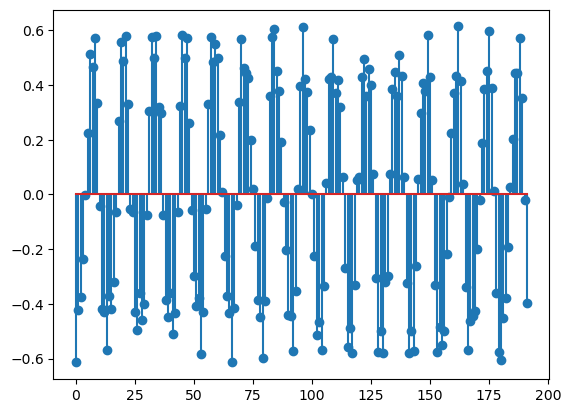

In [71]:
plt.stem(V_all[100, :])

In [72]:
V_all = np.expand_dims(V_all,2)

In [73]:
V_vae_train, V_vae_test = train_test_split(
    V_all, test_size=0.05, shuffle=True, random_state=52
)

In [74]:
print(V_vae_train.shape, V_vae_test.shape)
print(np.min(V_all), np.max(V_all))

(2847, 192, 1) (150, 192, 1)
-0.6159002458182258 0.6159002458182258


In [75]:
history = vae.fit(V_vae_train, epochs=150, batch_size=64)
#history = vae.fit(V_all, epochs=50, batch_size=32)

Epoch 1/150
45/45 [==============================] - 4s 11ms/step - loss: 0.1358 - reconstruction_loss: 0.1213 - kl_loss: 2.9649e-05
Epoch 2/150
45/45 [==============================] - 0s 11ms/step - loss: 0.0820 - reconstruction_loss: 0.0796 - kl_loss: 1.7153e-06
Epoch 3/150
45/45 [==============================] - 0s 11ms/step - loss: 0.0765 - reconstruction_loss: 0.0764 - kl_loss: 2.0842e-07
Epoch 4/150
45/45 [==============================] - 0s 11ms/step - loss: 0.0759 - reconstruction_loss: 0.0760 - kl_loss: 1.1290e-07
Epoch 5/150
11/45 [======>.......................] - ETA: 0s - loss: 0.0758 - reconstruction_loss: 0.0758 - kl_loss: 6.9680e-08

KeyboardInterrupt: 

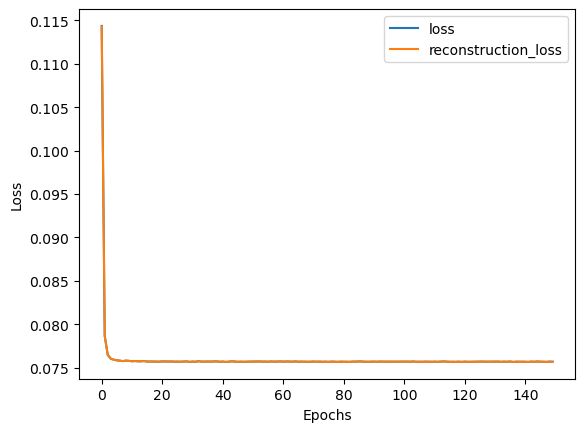

In [42]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["reconstruction_loss"], label="reconstruction_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [43]:
z_mean, z_log_var, latent_data = vae.encoder.predict(V_vae_test[::1])

5/5 [==============================] - 0s 27ms/step


### Build LSTM

In [46]:
V_30 = np.expand_dims(V_30,2)
V_35 = np.expand_dims(V_35,2)
V_40 = np.expand_dims(V_40,2)


V_z_mean_30, V_z_log_var_30, V_z_30 = vae.encoder.predict(V_30)
V_z_mean_35, V_z_log_var_35, V_z_35 = vae.encoder.predict(V_35)
V_z_mean_40, V_z_log_var_40, V_z_40 = vae.encoder.predict(V_40)

32/32 [==============================] - 0s 2ms/step


In [47]:
scaler_V_z_30 = MinMaxScaler()
scaler_V_z_35 = MinMaxScaler()
scaler_V_z_40 = MinMaxScaler()

scaler_V_z_30.fit(V_z_30)
scaler_V_z_35.fit(V_z_35)
scaler_V_z_40.fit(V_z_40)

V_z_30 = scaler_V_z_30.transform(V_z_30)
V_z_35 = scaler_V_z_35.transform(V_z_35)
V_z_40 = scaler_V_z_40.transform(V_z_40)

In [48]:
# creates overlapping segments with a length of nseg
nseg = 3

X0_30 = [V_z_30[n : n + nseg, :] for n in range(V_z_30.shape[0] - nseg + 1)]
X0_30 = np.array(X0_30)

X0_35 = [V_z_35[n : n + nseg, :] for n in range(V_z_35.shape[0] - nseg + 1)]
X0_35 = np.array(X0_35)

X0_40 = [V_z_40[n : n + nseg, :] for n in range(V_z_40.shape[0] - nseg + 1)]
X0_40 = np.array(X0_40)

Y0_30 = np.array(V_z_30[nseg - 1 :])
Y0_35 = np.array(V_z_35[nseg - 1 :])
Y0_40 = np.array(V_z_40[nseg - 1 :])

In [49]:
print(X0_30.shape, Y0_30.shape)
print(X0_35.shape, Y0_35.shape)
print(X0_40.shape, Y0_40.shape)

(997, 3, 4) (997, 4)
(997, 3, 4) (997, 4)
(997, 3, 4) (997, 4)


In [50]:
X0_30_35_40 = np.concatenate((X0_30, X0_35, X0_40))
Y0_30_35_40 = np.concatenate((Y0_30, Y0_35, Y0_40))
print(X0_30_35_40.shape, Y0_30_35_40.shape)

(2991, 3, 4) (2991, 4)


In [51]:
X_lstm_train, X_lstm_test, Y_lstm_train, Y_lstm_test = train_test_split(
    X0_30_35_40, Y0_30_35_40, test_size=0.05, shuffle=True, random_state=52
)

In [52]:
print(X_lstm_train.shape, Y_lstm_train.shape)
print(X_lstm_test.shape, Y_lstm_test.shape)

print(np.min(X_lstm_train), np.max(X_lstm_train))
print(np.median(X_lstm_train))

(2841, 3, 4) (2841, 4)
(150, 3, 4) (150, 4)
0.0 1.0
0.492705


In [53]:
def lstm_split(input_shape, nseg, v_shape):
    def Slice(s):
        # function for slicing x
        def func(x):
            return x[:, s, :]

        return func

    # define shared layers
    dense = Dense(v_shape, activation="relu")
    inputs = Input(shape=input_shape)
    con_list = []
    for s in range(nseg):
        # slicing x
        x = Lambda(Slice(s))(inputs)
        # shared layers
        x = dense(x)
        con_list.append(x)

    # concat and reshape for LSTM
    x = Concatenate(axis=1)(con_list)
    x = Reshape((nseg, int(x.shape[1] / nseg)))(x)

    x = LSTM(v_shape)(x)
    x = Activation("softmax")(x)

    return Model(inputs, x)

In [54]:
lstm = lstm_split(
    input_shape=(nseg, latent_dim), nseg=nseg, v_shape=Y0_30_35_40.shape[1]
)
lstm.compile(optimizer="adam", loss="binary_crossentropy")
print(lstm.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 3, 4)]       0           []                               
                                                                                                  
 lambda (Lambda)                (None, 4)            0           ['input_11[0][0]']               
                                                                                                  
 lambda_1 (Lambda)              (None, 4)            0           ['input_11[0][0]']               
                                                                                                  
 lambda_2 (Lambda)              (None, 4)            0           ['input_11[0][0]']               
                                                                                              

2023-11-01 07:44:04.267904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-01 07:44:04.269200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-01 07:44:04.270030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [55]:
epochs = 100
batch_size = 8

history = lstm.fit(
    X_lstm_train,
    Y_lstm_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_lstm_test, Y_lstm_test),
)

Epoch 1/100


2023-11-01 07:44:07.953044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-01 07:44:07.954344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-01 07:44:07.955386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

356/356 [==============================] - 4s 6ms/step - loss: 0.6931 - val_loss: 0.6904
Epoch 2/100
  1/356 [..............................] - ETA: 2s - loss: 0.6863

2023-11-01 07:44:11.662453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-01 07:44:11.664090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-01 07:44:11.665187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

356/356 [==============================] - 2s 5ms/step - loss: 0.6892 - val_loss: 0.6869
Epoch 3/100
356/356 [==============================] - 2s 5ms/step - loss: 0.6842 - val_loss: 0.6815
Epoch 4/100
356/356 [==============================] - 2s 5ms/step - loss: 0.6781 - val_loss: 0.6760
Epoch 5/100
356/356 [==============================] - 2s 5ms/step - loss: 0.6730 - val_loss: 0.6724
Epoch 6/100
356/356 [==============================] - 2s 5ms/step - loss: 0.6692 - val_loss: 0.6682
Epoch 7/100
356/356 [==============================] - 2s 5ms/step - loss: 0.6662 - val_loss: 0.6656
Epoch 8/100
356/356 [==============================] - 2s 5ms/step - loss: 0.6637 - val_loss: 0.6625
Epoch 9/100
356/356 [==============================] - 2s 5ms/step - loss: 0.6614 - val_loss: 0.6601
Epoch 10/100
356/356 [==============================] - 2s 5ms/step - loss: 0.6593 - val_loss: 0.6580
Epoch 11/100
356/356 [==============================] - 2s 5ms/step - loss: 0.6576 - val_loss: 0.6564


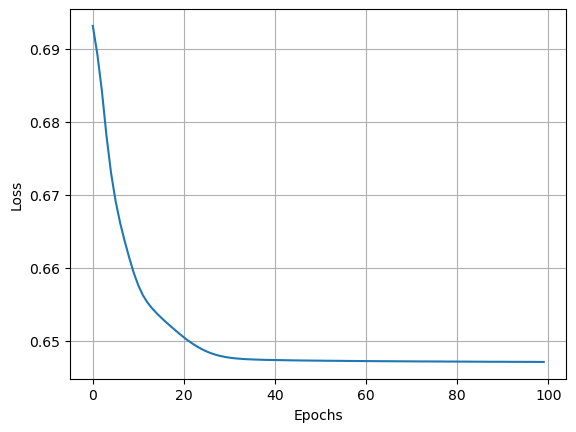

In [57]:
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [36]:
# 1. Vae -> komprimieren der nsegs
# 2. lstm vorhersage

In [37]:
print(X_lstm_test.shape, Y_lstm_test.shape)

(150, 6, 4) (150, 4)


In [38]:
pred = lstm.predict(X_lstm_test)

5/5 [==============================] - 0s 3ms/step


2023-10-25 13:50:40.523841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 13:50:40.525420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 13:50:40.526466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [46]:
print(np.min(pred), np.max(pred))

0.08364128 0.53969795


In [48]:
pred[:10, :]

array([[0.2605515 , 0.11665384, 0.41450116, 0.20829342],
       [0.23822479, 0.21181425, 0.38134688, 0.16861403],
       [0.53969795, 0.13380113, 0.156181  , 0.1703199 ],
       [0.20147453, 0.4974184 , 0.1736638 , 0.12744331],
       [0.35672218, 0.36690778, 0.15316573, 0.12320436],
       [0.418584  , 0.19023915, 0.16446017, 0.22671673],
       [0.16490652, 0.1511956 , 0.18194988, 0.501948  ],
       [0.2980979 , 0.10781483, 0.23442483, 0.35966247],
       [0.12892966, 0.2673646 , 0.30734262, 0.2963631 ],
       [0.2835973 , 0.08830997, 0.3277329 , 0.30035982]], dtype=float32)

In [47]:
Y_lstm_test[:10, :]

array([[0.5613042 , 0.38819155, 0.7147909 , 0.51056236],
       [0.5624202 , 0.53115565, 0.62649417, 0.464075  ],
       [0.7175732 , 0.15813604, 0.33417314, 0.34232813],
       [0.41965017, 0.67829144, 0.41213134, 0.20872739],
       [0.60504425, 0.5916996 , 0.38899198, 0.22219327],
       [0.4948507 , 0.33252603, 0.37557745, 0.40572497],
       [0.2855835 , 0.29082155, 0.43736342, 0.73428196],
       [0.4782172 , 0.21870042, 0.51732796, 0.5659602 ],
       [0.40764198, 0.56408465, 0.5891058 , 0.57915795],
       [0.8250408 , 0.4334951 , 0.7465727 , 0.72105426]], dtype=float32)

In [55]:
V_dec_40 = np.array(vae.decoder(pred_40))

<StemContainer object of 3 artists>

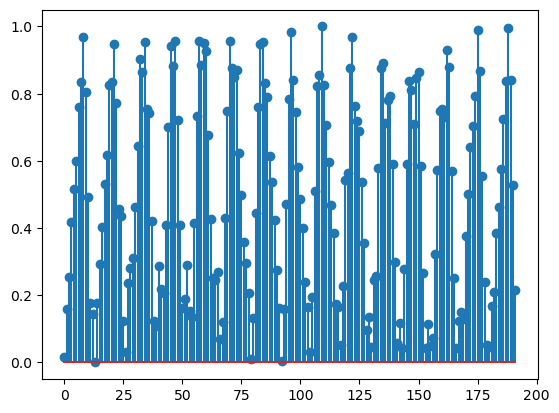

In [56]:
plt.stem(norm_data(V_40[14, :]))

### Inverse transform from VAE beginning

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# scalar.inverse_transform(X)

<StemContainer object of 3 artists>

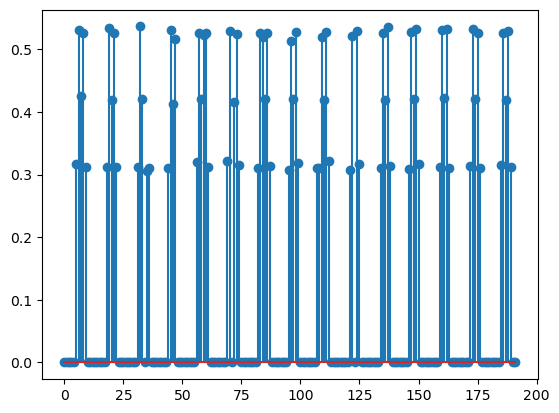

In [57]:
plt.stem(V_dec_40[14, :])

In [40]:
tmp_1 = np.load(load_path_40 + "sample_000000.npz", allow_pickle=True)
tmp_2 = np.load(load_path_40 + "sample_000015.npz", allow_pickle=True)

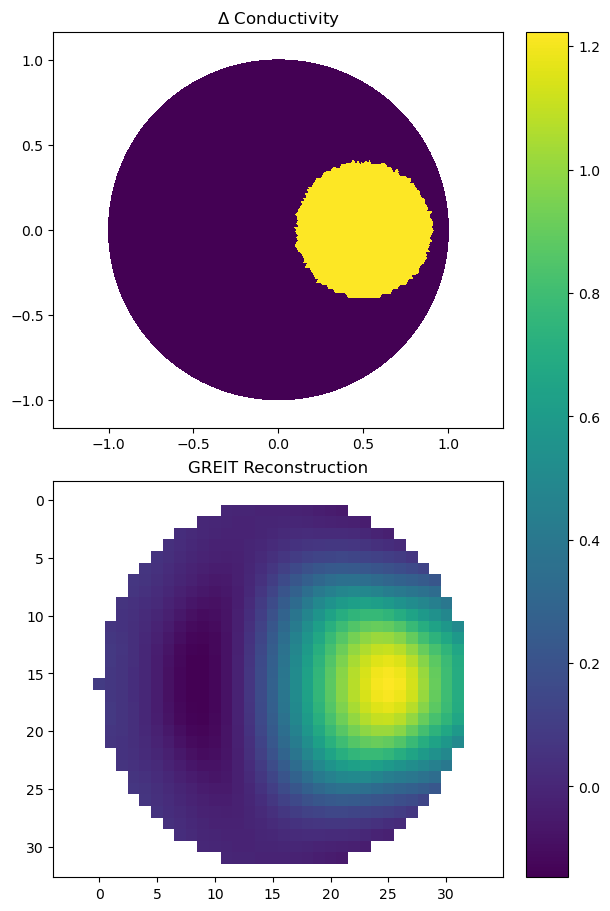

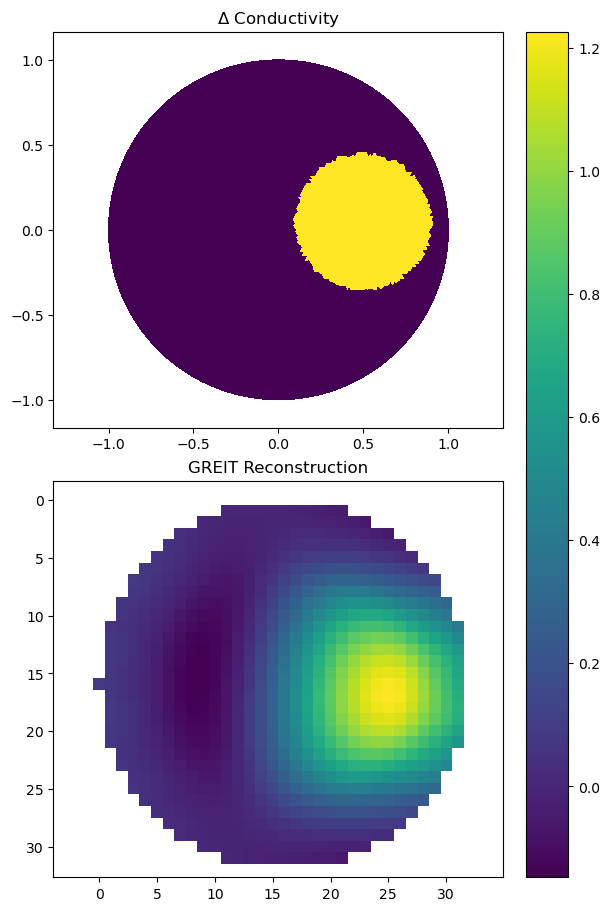

In [41]:
GREIT_sample(tmp_1,rec_only=False)
GREIT_sample(tmp_2,rec_only=False)

In [42]:
tmp_s = {
    "anomaly": tmp_1["anomaly"],
    "perm_array": tmp_1["perm_array"],
    "n_el": tmp_1["n_el"],
    "h0": tmp_1["h0"],
    "v_empty": tmp_1["v_obj"],
    "v_obj":  tmp_2["v_obj"],
    "dist_exc": tmp_1["dist_exc"],
    "step_meas": tmp_1["step_meas"],
}

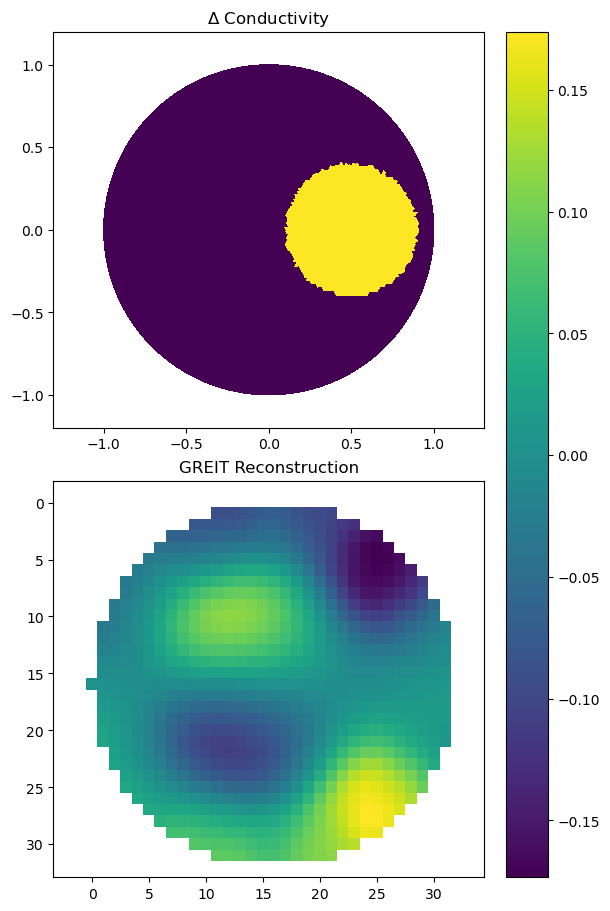

In [43]:
GREIT_sample(tmp_s, rec_only=False)

In [48]:
tmp_1["perm_array"].shape

(11433,)